<a href="https://colab.research.google.com/github/yohancsx/SmartMask/blob/main/tf_lite/BleSenseSmartMaskML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Notebook for the BLE Smart Mask Project
Trains the tf model to recognize various pressure changes and correlate to behaviors which are talking, coughing, heavy breathing and light breathing.
Also converts the model into arduino-friendly format.

In [33]:
#set up the notebook
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.0.0-rc1

In [48]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [49]:
#load all the data into seperate dataframes

#the name for the breathing data
breathingFile = "40s_breathing.csv"

#the name for the coughing data
coughingFile = "40s_coughing.csv"

#the filename for the talking data
talkingFile = "40s_talking.csv"

#the filename for the deep breathing data
deepBreathingFile = "40s_deep_breathing.csv"

#the filename for the combined data
combinedFile = "40s_mixed.csv"

#plot some of the data on the same axes
dfTalk = (pd.read_csv("/content/" + talkingFile, index_col=False, header=None, names = ["pressure", "RMS"])).dropna(axis = 1)
dfBreathe = (pd.read_csv("/content/" + breathingFile, index_col=False, header=None, names = ["pressure", "RMS"])).dropna(axis = 1)
dfCough = (pd.read_csv("/content/" + coughingFile, index_col=False, header=None, names = ["pressure", "RMS"])).dropna(axis = 1)
dfDeepBreathe = (pd.read_csv("/content/" + deepBreathingFile, index_col=False, header=None, names = ["pressure", "RMS"])).dropna(axis = 1)
dfMixed = (pd.read_csv("/content/" + talkingFile, index_col=False, header=None, names = ["pressure", "RMS"])).dropna(axis = 1)

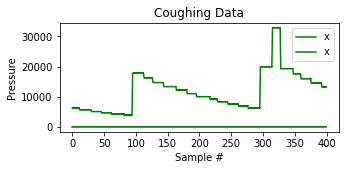

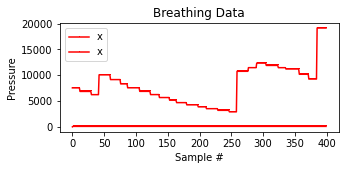

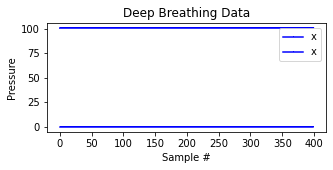

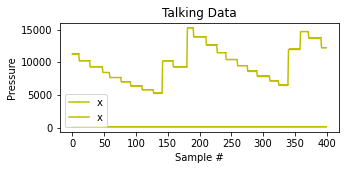

In [51]:
#plot some of the sample data
plt.rcParams["figure.figsize"] = (5,2)

#the indices
index = range(0, 400)

plt.plot(index, dfCough.head(400), 'g.', label='x', linestyle='solid', marker=',')
plt.title("Coughing Data")
plt.xlabel("Sample #")
plt.ylabel("Pressure")
plt.legend()
plt.show()

plt.plot(index, dfBreathe.head(400), 'r.', label='x', linestyle='solid', marker=',')
plt.title("Breathing Data")
plt.xlabel("Sample #")
plt.ylabel("Pressure")
plt.legend()
plt.show()

plt.plot(index, dfDeepBreathe.head(400), 'b.', label='x', linestyle='solid', marker=',')
plt.title("Deep Breathing Data")
plt.xlabel("Sample #")
plt.ylabel("Pressure")
plt.legend()
plt.show()

plt.plot(index, dfTalk.head(400), 'y.', label='x', linestyle='solid', marker=',')
plt.title("Talking Data")
plt.xlabel("Sample #")
plt.ylabel("Pressure")
plt.legend()
plt.show()




In [80]:
#prepare the datasets

#set the random seed
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

#the list of breathing types to classify
BREATHING_TYPES = [
    "coughing",
    "breathing",
    "talking"
]

#the list of dataframes of the breathing types
BREATHING_DATA_LIST = [dfCough,dfBreathe,dfTalk]

#the raw number of samples per period
SAMPLES_PER_PERIOD = 400

NUM_TYPES = len(BREATHING_TYPES)

#create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_TYPES = np.eye(NUM_TYPES)


#input and putput files
inputs = []
outputs = []

#set to a number far greater than the maximum number of samples (or infinity)
minsamples = np.inf

#the maximum pressure value so data is between 0 and 1
maxpressure = 3000

#find the min number of samples, also the max value
for type_index in range(NUM_TYPES):
  #get the type data
  type_data = BREATHING_DATA_LIST[type_index]
  
  if((type_data.shape[0] - SAMPLES_PER_PERIOD/2) < minsamples):
    minsamples = type_data.shape[0] - SAMPLES_PER_PERIOD/2
  
display("minimum samples:")
display(minsamples)

'minimum samples:'

41133.0

In [79]:
#Option 1: split the dataset into overlapping portions

for type_index in range(NUM_TYPES):
  #get the type data
  type_data = BREATHING_DATA_LIST[type_index]

  #get the tensors with the samples, start by getting the first sampling period until the last
  for i in range(int(SAMPLES_PER_PERIOD/2), int(minsamples)):
    tensor = []
    output = ONE_HOT_ENCODED_TYPES[type_index]
    for j in range(SAMPLES_PER_PERIOD):
      dataIndex = i + j - SAMPLES_PER_PERIOD/2
      tensor += [type_data['pressure'][dataIndex]/maxpressure,type_data['RMS'][dataIndex]/50000]
  
    #append the data
    inputs.append(tensor)
    outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)

display(inputs.shape)
display(outputs.shape)

KeyboardInterrupt: ignored

In [81]:
#Option 2: split the dataset into non-overlapping portions
for type_index in range(NUM_TYPES):
  #get the type data
  type_data = BREATHING_DATA_LIST[type_index]

  #get the tensors with the samples, start by getting the first sampling period until the last
  for i in range(int(minsamples/SAMPLES_PER_PERIOD)):
    tensor = []
    output = ONE_HOT_ENCODED_TYPES[type_index]
    for j in range(SAMPLES_PER_PERIOD):
      dataIndex = SAMPLES_PER_PERIOD*i + j
      tensor += [type_data['pressure'][dataIndex]/maxpressure,type_data['RMS'][dataIndex]/50000]
  
    #append the data
    inputs.append(tensor)
    outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)
display(inputs.shape)
display(outputs.shape)

(306, 800)

(306, 3)

In [82]:
#randomize and split inputs and outputs into training and test sets
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

#swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

#split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

In [83]:
#build the model and train it, with 2 densely connected relu layers and softmax output
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_TYPES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [84]:
#train the model
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Train on 183 samples, validate on 62 samples
Epoch 1/600
183/183 [==============================] - 1s 6ms/sample - loss: 0.2229 - mae: 0.4291 - val_loss: 0.2405 - val_mae: 0.4406
Epoch 2/600
183/183 [==============================] - 1s 3ms/sample - loss: 0.2218 - mae: 0.4326 - val_loss: 0.2249 - val_mae: 0.4267
Epoch 3/600
183/183 [==============================] - 1s 3ms/sample - loss: 0.2115 - mae: 0.4177 - val_loss: 0.2064 - val_mae: 0.4142
Epoch 4/600
183/183 [==============================] - 1s 3ms/sample - loss: 0.2099 - mae: 0.4160 - val_loss: 0.2026 - val_mae: 0.4085
Epoch 5/600
183/183 [==============================] - 1s 3ms/sample - loss: 0.2076 - mae: 0.4103 - val_loss: 0.2059 - val_mae: 0.4026
Epoch 6/600
183/183 [==============================] - 1s 3ms/sample - loss: 0.2067 - mae: 0.4051 - val_loss: 0.1886 - val_mae: 0.3926
Epoch 7/600
183/183 [==============================] - 0s 3ms/sample - loss: 0.2039 - mae: 0.4022 - val_loss: 0.2212 - val_mae: 0.4127
Epoch 8/60

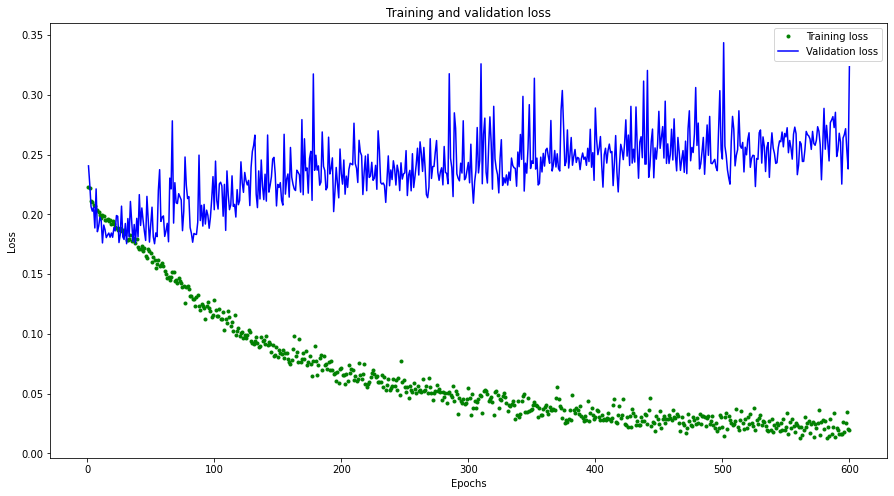

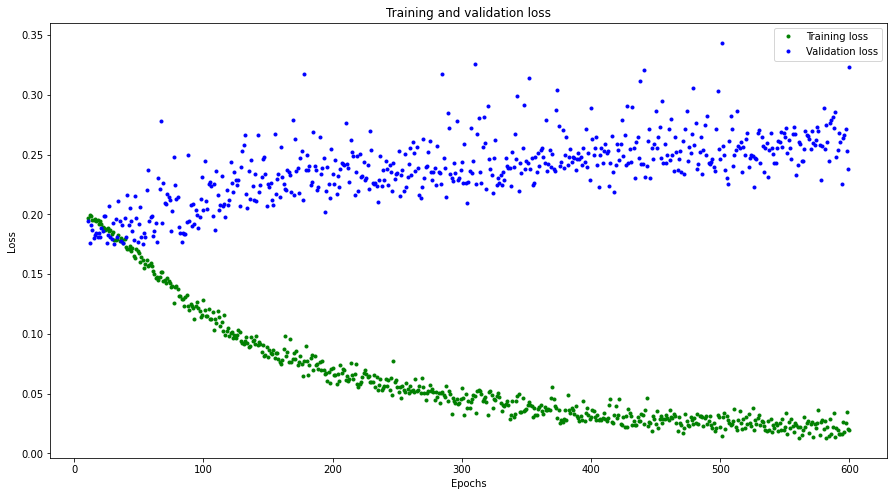

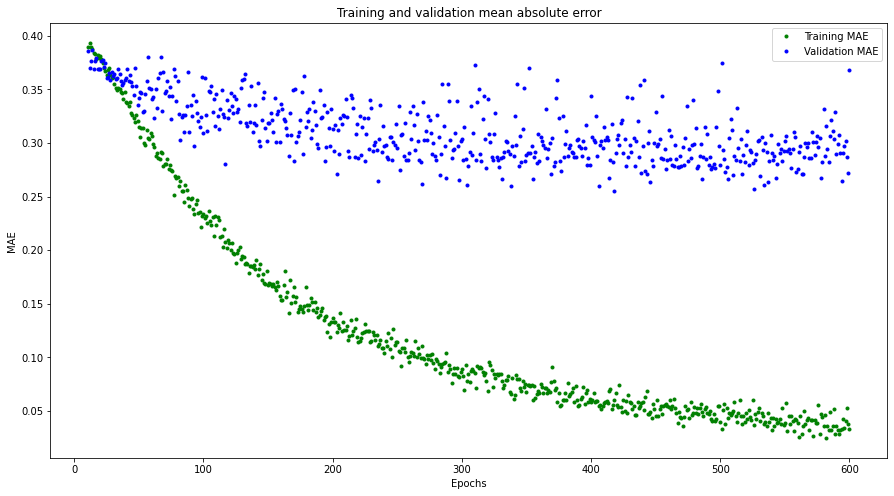

In [85]:
plt.rcParams["figure.figsize"] = (15,8)

#graph the loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#graph the loss again skipping a bit of the start
SKIP = 10
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [86]:
#use the model to predict the test inputs
predictions = model.predict(inputs_test)
display(np.argmax(outputs_test,1))
display(np.argmax(predictions,1))

#get the model accuracy
test_loss, test_acc = model.evaluate(inputs_test, outputs_test)
print('Test accuracy:', test_acc)

display(tf.math.confusion_matrix(np.argmax(outputs_test,1),np.argmax(predictions,1)))


array([0, 0, 0, 1, 1, 1, 0, 2, 1, 1, 2, 1, 0, 0, 1, 0, 2, 2, 2, 2, 0, 2,
       2, 0, 2, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 0,
       2, 2, 2, 1, 2, 2, 2, 1, 2, 0, 0, 1, 1, 0, 2, 1, 0])

array([0, 0, 0, 1, 1, 1, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0,
       2, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 1, 2,
       2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2])

61/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

<tf.Tensor: id=867399, shape=(3, 3), dtype=int32, numpy=
array([[13,  2,  2],
       [ 2, 14,  1],
       [ 8, 11,  8]], dtype=int32)>